# Outlier Idenfication algorithm
This file create 2 new features for each transaction:
1. Natural_var: This is a boolean attribute, indicating if a transaction's respective merchant sells more than one type of item ($157) 
2. Potential_outlier: This determines if a transactions dollar_value is outside the 'normal' distribution

Please Note: Transactios with dollar_values under $1 have not been removed

In [23]:
# Open Spark session 
from pyspark.sql import SparkSession, functions as F


# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Data_Explorer")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "6g")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .getOrCreate()
)

In [24]:
# Read the files 
transactions_sample = spark.read.parquet('../data/tables/transactions_20210828_20220227_snapshot')
transactions_sample2 = spark.read.parquet('../data/tables/transactions_20210228_20210827_snapshot')
transactions_sample3 = spark.read.parquet('../data/tables/transactions_20220228_20220828_snapshot')
transactions_sample.unionByName(transactions_sample2, True)
transactions_sample.unionByName(transactions_sample3, True)
consumer_details = spark.read.parquet('../data/tables/consumer_user_details.parquet')
merchants_tbl = spark.read.parquet('../data/tables/tbl_merchants.parquet')
customer_tbl = spark.read.option("delimiter", "|").option("header",True).csv('../data/tables/tbl_consumer.csv')

In [25]:
merchants = merchants_tbl.toPandas()

In [26]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
import string

# This is used to for NLP of the description
def text_process(text):
    stemmer = WordNetLemmatizer()
    # Remove all punctuation and numbers 
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    # Remove all stopwords
    nopunc =  [word.lower() for word in nopunc.split() if word not in stopwords.words('english')]
    # lemmatize and output
    return ' '.join([stemmer.lemmatize(word) for word in nopunc])

In [27]:
# this function standardises the tags attribute, creating a list with the 'description', 'revenue band' and 'BNPL service charge'
def tag_extract(tag_string): 
    # first need to preprocess
    string =  re.sub('\[','(', tag_string.lower())
    string = re.sub('\]',')', string)
    # break the string into sections
    string_cut = string.split('),')
    new_string = []
    # first extract the description and pre process
    descr = str(string_cut[0].strip('(('))
    #descr = re.sub(r'[-|,|_|:]', ' ', descr)
    #descr = re.sub(r' +', ' ', descr)
    #descr = descr.split()
    #descr = ' '.join([word for word in descr if word not in stop_words])
    new_string.append(text_process(descr))
    # second extract the band
    new_string.append(str(re.search(r'[a-z]',string_cut[1]).group()))
    # finally the take rate
    new_string.append(float(re.search(r'[0-9]+\.[0-9]+',string_cut[2]).group()))
    return(new_string)
################
# now we can run the algorithm
tags = merchants['tags']
processed_tags = []
for i in tags:
    processed_tags.append(tag_extract(i))

In [28]:
import pandas as pd
merchant_tbl = pd.DataFrame(processed_tags, columns=('Description', 'Earnings_Class', 'BNPL_Fee'))
merchant_tbl = pd.concat([merchants, merchant_tbl], axis=1)
# drop the tags column 
merchant_tbl.drop(columns='tags', inplace=True)

In [29]:
# and convert back to spark dataframe 
merchants_tbl = spark.createDataFrame(merchant_tbl)

In [30]:
# This could be further expanded in breaking the discription up further

In [31]:
customer_tbl = customer_tbl.join(consumer_details, ['consumer_id'])

In [32]:
full_dataset = transactions_sample.join(customer_tbl, ['user_id'])
merchants_tbl = merchants_tbl.withColumnRenamed('name','company_name')
full_dataset = full_dataset.join(merchants_tbl, ['merchant_abn'])

In [33]:
# lets add a day (mon,...), weekly & monthly attribute
import pyspark.sql.functions as F
full_dataset = full_dataset.withColumn('Day', F.dayofweek('order_datetime'))
full_dataset = full_dataset.withColumn('Month', F.month('order_datetime'))
# now we can also add the bnpl revenue from a transaction 
full_dataset = full_dataset.withColumn('BNPL_Revenue', F.col('dollar_value') * 0.01 * F.col('BNPL_Fee'))
full_dataset.createOrReplaceTempView('data')
# we can remove name, location and customerID for now, due to being unnnesesary attributes (although company_name could also be removed)
full_dataset = spark.sql("""
select merchant_abn, user_id, dollar_value, order_id, order_datetime, state, postcode, gender, company_name, 
        Description, Earnings_Class, BNPL_Fee, BNPL_Revenue, Day, Month, weekofyear(order_datetime) as weekofyear from data
""")

# Outlier detection algorithm
This will be inplemented by creating an attribute called 'potential outlier'. which marks dollar values of transactios that fall out of a companies specific SIQR as True, and False otherwise. Furthermore, it marks all transactions that belong to a company, which has no variance in the dollar value of respective transactios. This is due to it being unrealistic/dodgy.

In [34]:
# use the SIQR range
# see https://towardsdatascience.com/outlier-detection-part-2-6839f6199768
Fst_percentile = F.expr('percentile_approx(dollar_value, 0.25)')
Trd_percentile = F.expr('percentile_approx(dollar_value, 0.75)')
Second_percentile = F.expr('percentile_approx(dollar_value, 0.5)')
quartile_dataset = full_dataset.groupBy('merchant_abn').agg(Fst_percentile.alias('1_val'), Trd_percentile.alias('3_val'), Second_percentile.alias('2_val'), F.count('dollar_value').alias('Count'))
quartile_dataset = quartile_dataset.withColumn('SIQR_Lower', F.col('2_val') - F.col('1_val'))
quartile_dataset = quartile_dataset.withColumn('SIQR_Upper', F.col('3_val') - F.col('2_val'))
# Now calculate the limits
quartile_dataset = quartile_dataset.withColumn('Upper_limit', F.col('3_val') + 3 * F.col('SIQR_Upper'))
quartile_dataset = quartile_dataset.withColumn('Lower_limit', F.col('1_val') - 3 * F.col('SIQR_Lower'))
# after noticing that some merchants only have one transaction value (i.e one dollar_value amount for all transactios)
# decided to removed due to unrealisic distributed data 
quartile_dataset = quartile_dataset.withColumn('Natural_var', F.when((F.col('Upper_limit') == F.col('Lower_limit')) & (F.col('Count') > 10), True).otherwise(False))
quartile_dataset = quartile_dataset.select('merchant_abn', 'Upper_limit', 'Lower_limit', 'Natural_var')

In [35]:
# Now all we need to do is join this data to each transaction, then can select the transactios which are (not) within the limits
full_quantile = full_dataset.select('merchant_abn', 'order_id', 'user_id', 'dollar_value').join(quartile_dataset, on= ['merchant_abn'])

In [36]:
# finally identify the outliers which fall out of distribution or apart of a dodgy business
full_quantile = full_quantile.withColumn('Potential_Outlier', F.when((full_quantile.dollar_value <= F.col('Upper_limit')) & (full_quantile.dollar_value >= F.col('Lower_limit')) & (F.col('Natural_var') == False), False)
                                              .otherwise(True))

In [37]:
full_quantile.where(F.col('Potential_Outlier') == True).count()

108528

<AxesSubplot:xlabel='dollar_value', ylabel='Count'>

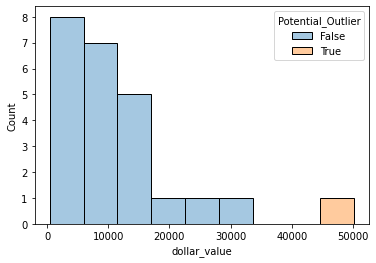

In [38]:
import seaborn as sns
sns.histplot(x='dollar_value', hue = 'Potential_Outlier',alpha = 0.4, data=full_quantile.where(full_quantile.merchant_abn == 35575706403).select('dollar_value', 'Potential_Outlier').toPandas())

In [39]:
full_quantile.show(10)

+------------+--------------------+-------+------------------+-----------------+-------------------+-----------+-----------------+
|merchant_abn|            order_id|user_id|      dollar_value|      Upper_limit|        Lower_limit|Natural_var|Potential_Outlier|
+------------+--------------------+-------+------------------+-----------------+-------------------+-----------+-----------------+
| 10023283211|654b3e5c-60cf-486...|   1277|313.00851867046595|628.6692521901441|-106.21679174673608|      false|            false|
| 10023283211|6c430ab1-1b80-422...|  21640| 83.27347382969296|628.6692521901441|-106.21679174673608|      false|            false|
| 10023283211|f7495160-7791-49f...|   4082|16.418930563461508|628.6692521901441|-106.21679174673608|      false|            false|
| 10023283211|1bcfd2f4-8287-44f...|  15327| 375.1821017323773|628.6692521901441|-106.21679174673608|      false|            false|
| 10023283211|e6dc35f3-1242-464...|  20792| 65.55664658902526|628.6692521901441|-10

# Description Tag analysis
There are a total of 26 unique tags, so lets look further into detail of differences between them

In [40]:
# First lets join the new attributes obtained above to the transaction spark dataframe
full_quantile = full_quantile.select(['order_id', 'Natural_var', 'Potential_Outlier'])
full_dataset = full_dataset.join(full_quantile, on='order_id')

In [49]:
# Remove transactions below $1
main_agg = full_dataset.where(full_dataset.dollar_value >= 1.0).groupBy('Description').agg(
    F.count('order_id').alias('Count'),
    F.count_distinct('merchant_abn').alias('Merchant_Number'),
    F.count_distinct('postcode').alias('Unique_Postcodes'),
    F.count_distinct('state').alias('Unique_Postcodes'),
    F.avg('dollar_value').alias('Dollar_AVG'),
    F.avg('BNPL_Fee').alias('BNPL_Fee'),
    F.avg('BNPL_Revenue').alias('BNPL_Revenue_AVG'),
    F.min('dollar_value').alias('Dollar_MIN'),
    F.max('dollar_value').alias('Dollar_MAX')
)

Outlier_agg1 = full_dataset.where(full_dataset.Potential_Outlier==True).groupBy('Description').agg(F.count('Potential_Outlier').alias('Potential_count'))
Outlier_agg2 = full_dataset.where(full_dataset.Natural_var==True).groupBy('Description').agg(F.count('Natural_var').alias('Nat_var_count'))
main_agg = main_agg.join(Outlier_agg1,  on='Description', how='left')
main_agg = main_agg.join(Outlier_agg2, on='Description', how='left')
main_agg = main_agg.withColumn('Potential_count', F.col('Potential_count') / F.col('Count'))
main_agg = main_agg.withColumn('Nat_var_count', F.col('Nat_var_count') / F.col('Count'))

# merchant_abn, user_id, dollar_value, order_id, order_datetime, state, postcode, gender, company_name, 
#        Description, Earnings_Class, BNPL_Fee, BNPL_Revenue, Day, Month, weekofyear(order_datetime) as weekofyear from data

In [50]:
main_bb = main_agg.toPandas()

In [52]:
main_bb.sort_values(by=['BNPL_Revenue_AVG'])

,Description,Count,Merchant_Number,Unique_Postcodes,Unique_Postcodes,Dollar_AVG,BNPL_Fee,BNPL_Revenue_AVG,Dollar_MIN,Dollar_MAX,Potential_count,Nat_var_count
16,digital good book movie music,405166,195,3165,8,64.718097,4.902642,3.256924,1.000124,697.705994,0.022805,NaN
5,gift card novelty souvenir shop,515739,182,3165,8,68.643582,4.731712,3.316062,1.000176,676.658510,0.021999,NaN
22,watch clock jewelry repair shop,325240,170,3165,8,73.562719,5.163520,3.651345,1.001248,871.997782,0.021787,NaN
10,tent awning shop,566509,178,3165,8,82.461472,4.712769,3.890528,1.000001,6692.205127,0.017569,NaN
20,cable satellite pay television radio service,302576,175,3165,8,79.150320,4.903767,3.902933,1.000150,625.627298,0.065035,0.042049
14,optician optical good eyeglass,262915,151,3165,8,89.724183,4.012606,3.952415,1.000367,1698.846916,0.028332,NaN
24,florist supply nursery stock flower,279152,180,3165,8,116.803682,4.047966,5.133672,1.000704,2294.783487,0.022378,NaN
19,computer computer peripheral equipment software,226698,181,3165,8,168.373765,4.213358,7.295526,1.001477,2820.859962,0.022638,NaN
18,computer programming data processing integrate...,164074,191,3165,8,191.868874,4.437372,8.652370,1.001176,9329.821463,0.023386,NaN
6,shoe shop,136525,185,3165,8,200.497741,4.495322,8.939275,1.000018,2335.699184,0.023703,NaN
